In [3]:
import pandas as pd
from tqdm import tqdm
import os
import cv2
from glob import glob
import random as rnd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras import layers
from keras.models import Model

In [2]:

data = pd.read_csv('/kaggle/input/distracted-driver-dataset/driver_imgs_list.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


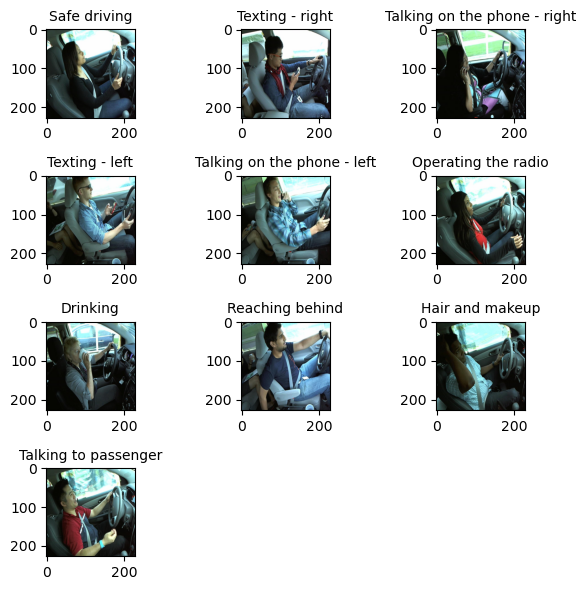

In [3]:
dic = {'c0': 'Safe driving',
                   'c1': 'Texting - right',
                   'c2': 'Talking on the phone - right', 
                   'c3': 'Texting - left', 
                   'c4': 'Talking on the phone - left',
                   'c5': 'Operating the radio', 
                   'c6': 'Drinking',
                   'c7': 'Reaching behind',
                   'c8': 'Hair and makeup', 
                   'c9': 'Talking to passenger'}
plt.figure(figsize = (6,6))
for idx,i in enumerate(data.classname.unique()):
    plt.subplot(4,3,idx+1)
    df = data[data['classname'] ==i].reset_index(drop = True)
    image = df.loc[rnd.randint(0, len(df)), 'img']
    link = '/kaggle/input/distracted-driver-dataset/imgs/train/'+i+'/'+image
    img = Image.open(link)
    img = img.resize((227,227))
    plt.imshow(img)
    plt.title(dic[i],fontsize = 10)
    plt.tight_layout()
plt.show()

In [4]:
def loading_data(link,size):
   data_images =[]
   data_labels= []
   for cls in tqdm(range(10)):
       print('loading images in directoy c{}'.format(cls))
       files = glob(os.path.join(str(link)+'/c'+str(cls),'*.jpg'))
       images = rnd.sample(files,1000)
       for image in images:
           img= cv2.imread(image,cv2.IMREAD_COLOR)
           img = cv2.resize(img, size)
           data_images.append(img)
           data_labels.append(cls)
   return data_images,data_labels      

In [5]:
link = '/kaggle/input/distracted-driver-dataset/imgs/train'

X,y= loading_data(link,(227,227))


  0%|          | 0/10 [00:00<?, ?it/s]

loading images in directoy c0


 10%|█         | 1/10 [00:12<01:51, 12.35s/it]

loading images in directoy c1


 20%|██        | 2/10 [00:24<01:36, 12.08s/it]

loading images in directoy c2


 30%|███       | 3/10 [00:36<01:26, 12.37s/it]

loading images in directoy c3


 40%|████      | 4/10 [00:50<01:16, 12.73s/it]

loading images in directoy c4


 50%|█████     | 5/10 [01:02<01:02, 12.55s/it]

loading images in directoy c5


 60%|██████    | 6/10 [01:14<00:49, 12.47s/it]

loading images in directoy c6


 70%|███████   | 7/10 [01:27<00:37, 12.51s/it]

loading images in directoy c7


 80%|████████  | 8/10 [01:39<00:24, 12.42s/it]

loading images in directoy c8


 90%|█████████ | 9/10 [01:51<00:12, 12.26s/it]

loading images in directoy c9


100%|██████████| 10/10 [02:03<00:00, 12.35s/it]


In [10]:
y_new= tf.keras.utils.to_categorical(y,num_classes=10)
trainX,testX,trainy,testy= train_test_split(X,y_new,test_size=0.2,random_state=1)
trainX=np.array(trainX,dtype =np.uint8).reshape(-1,227,227,3)
testX=np.array(testX,dtype =np.uint8).reshape(-1,227,227,3)
trainy=np.array(trainy,dtype =np.uint8)
testy=np.array(testy,dtype =np.uint8)


In [6]:
model = keras.Sequential(
   [   keras.Input(shape=(227, 227, 3)),
       layers.Flatten(),
       layers.Dense(400, activation ='relu'),
       layers.Dense(400, activation ='relu'),
       layers.Dense(100, activation = 'relu'),
       layers.Dense(10, activation = 'softmax')
       ]
       )
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()
   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 154587)            0         
                                                                 
 dense (Dense)               (None, 400)               61835200  
                                                                 
 dense_1 (Dense)             (None, 400)               160400    
                                                                 
 dense_2 (Dense)             (None, 100)               40100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 62,036,710
Trainable params: 62,036,710
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_sizes=[10, 500, 1000, 3000]

In [12]:
histories=[]
for size in batch_sizes: 
     print(size)
     history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=False, batch_size=size)
     histories.append(history)

10
500
1000
3000


In [2]:
c

NameError: name 'histories' is not defined

In [ ]:
accuracy =history.history['accuracy']
val_accuracy =history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']
d = {'accuray_train': accuray_train, 'accuray_test': accuray_test,'loss_train':loss_train,'loss_test':loss_test}
df = pd.DataFrame(data=d)
df.tail(n=5)


In [ ]:
titles= ['Accuracies','Losses']
accuracies=['accuray_train','accuray_test']
losses=['loss_train','loss_test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
fig.tight_layout()
#ax.set_title(titles[idx],pad=5)
axes[0].plot([i for i in range(len(df))],accuracy ,label="train")
axes[0].plot([i for i in range(len(df))],val_accuracy,label="train")
axes[1].plot([i for i in range(len(df))],loss ,label="train")
axes[1].plot([i for i in range(len(df))],val_loss,label="train")
    #ax.plot([i for i in range(len(df))],df.iloc[:,idx],label="test")
    #ax.plot(,label="positive")
    #ax.hist(negative.iloc[:,idx], bins =5, alpha=0.5,label= 'negative')
    #plt.xlim([0, max(dataset.iloc[:,idx])])
ax.legend(loc='upper right')
  

In [ ]:
history1 = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=True, batch_size=3000)

In [ ]:
accuracy =history1.history['accuracy']
val_accuracy =history1.history['val_accuracy']
loss=history1.history['loss']
val_loss = history1.history['val_loss']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
fig.tight_layout()
#ax.set_title(titles[idx],pad=5)
axes[0].plot([i for i in range(len(df))],accuracy ,label="train")
axes[0].plot([i for i in range(len(df))],val_accuracy,label="train")
axes[1].plot([i for i in range(len(df))],loss ,label="train")
axes[1].plot([i for i in range(len(df))],val_loss,label="train")

In [ ]:
history2 = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=True, batch_size=1000)

In [ ]:
accuracy =history2.history['accuracy']
val_accuracy =history2.history['val_accuracy']
loss=history2.history['loss']
val_loss = history2.history['val_loss']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
fig.tight_layout()
#ax.set_title(titles[idx],pad=5)
axes[0].plot([i for i in range(len(df))],accuracy ,label="train")
axes[0].plot([i for i in range(len(df))],val_accuracy,label="train")
axes[1].plot([i for i in range(len(df))],loss ,label="train")
axes[1].plot([i for i in range(len(df))],val_loss,label="train")

In [ ]:
history3 = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=True, batch_size=500)

In [ ]:
accuracy =history3.history['accuracy']
val_accuracy =history3.history['val_accuracy']
loss=history3.history['loss']
val_loss = history3.history['val_loss']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
fig.tight_layout()
#ax.set_title(titles[idx],pad=5)
axes[0].plot([i for i in range(len(df))],accuracy ,label="train")
axes[0].plot([i for i in range(len(df))],val_accuracy,label="train")
axes[1].plot([i for i in range(len(df))],loss ,label="train")
axes[1].plot([i for i in range(len(df))],val_loss,label="train")